# SCDAA Coursework 2024-25

**The University of Edinburgh**

Github link:

Zheyan Lu 

***NB***: the project is run in a Python version 3.12.9 and the version of some libraries used is as follows:

In [14]:
import numpy
import matplotlib
import torch
import scipy

print(f"NumPy version: {numpy.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}") 
print(f"PyTorch version: {torch.__version__}")
print(f"SciPy version: {scipy.__version__}")

NumPy version: 1.26.4
Matplotlib version: 3.7.5
PyTorch version: 2.5.1
SciPy version: 1.11.4


## Exercise 1.1

The LQR solver is written as a class in *lqr_solver.py*. We like to mention some important techinical details used in the class:

* The solver uses ***scipy.integrate.solve_ivp*** to solve the system. The choice of the RK45 method with tight tolerances (rtol and atol set to 1e-8) ensures high accuracy.
* Method value accepts a torch 1D tensor for time and a torch 2D tensor for the state $x$. It computes the value functionby first finding the index corresponding to the appropriate time grid value (using the helper ***_find_time_index*** method) and then performing the required tensor operations. This aligns with the exercise requirement to use the grid time that is nearest. 


Here comes a test example:

In [27]:
import torch, scipy
import numpy as np
import matplotlib.pyplot as plt
from lqr_solver import LQRProblem

# Example 2D system from the assignment
H = torch.tensor([[0.5, 0.5],
                  [0.0, 0.5]])
M = torch.tensor([[1.0, 1.0],
                  [0.0, 1.0]])
sigma = 0.5 * torch.eye(2)
C = torch.tensor([[1.0, 0.1],
                   [0.1, 1.0]])
D = 0.1 * torch.tensor([[1.0, 0.1],
                        [0.1, 1.0]])
R = 10.0 * torch.tensor([[1.0, 0.3],
                         [0.3, 1.0]])

T = 1
# e.g. 101 time points from 0..T
time_grid = np.linspace(0.0, T, 101)

# Initialize the LQR problem
lqr = LQRProblem(H, M, sigma, C, D, R, T, time_grid)

# Evaluate value function at some test points
t_test = torch.tensor([0.0, 0.25, 0.5, 1, 1.5])
x_test = torch.tensor([
        [1.0,  1.0],
        [2.0,  2.0],
        [2.0, -2.0],
        [1.0, -1.0],
        [1.0, -1.0]
    ])

print("Testing value(t, x):")
v_vals = lqr.value(t_test, x_test)
for (ti, xi, vi) in zip(t_test, x_test, v_vals):
    print(f"  v(t={ti.item()}, x={xi.tolist()}) = {vi.item():.4f}")

# Evaluate the optimal control
print("\nTesting optimal_control(t, x):")
a_star = lqr.optimal_control(t_test, x_test)
for (ti, xi, ai) in zip(t_test, x_test, a_star):
    print(f"  a*(t={ti.item()}, x={xi.tolist()}) = {ai.tolist()}")

Testing value(t, x):
  v(t=0.0, x=[1.0, 1.0]) = 0.8750
  v(t=0.25, x=[2.0, 2.0]) = 2.3957
  v(t=0.5, x=[2.0, -2.0]) = 5.4227
  v(t=1.0, x=[1.0, -1.0]) = 14.0000
  v(t=1.5, x=[1.0, -1.0]) = 14.0000

Testing optimal_control(t, x):
  a*(t=0.0, x=[1.0, 1.0]) = [-1.4239060878753662, -5.0703277587890625]
  a*(t=0.25, x=[2.0, 2.0]) = [-2.770057439804077, -10.185709953308105]
  a*(t=0.5, x=[2.0, -2.0]) = [-11.663199424743652, 4.6330084800720215]
  a*(t=1.0, x=[1.0, -1.0]) = [-70.70706939697266, 7.070707321166992]
  a*(t=1.5, x=[1.0, -1.0]) = [-70.70706939697266, 7.070707321166992]


## Exercise 1.2

We adopt the explicit scheme to do the Monte-Carlo simulations. The function and example test are as follows. 

In [25]:
#Monte Carlo
def simulate_explicit(problem, x0, T, N):
    """
    Simulate one trajectory of the SDE:
      dX = (H*X + M*a(t,X)) dt + sigma dW,
    with dt = T/N, starting from initial state x0.
    
    Returns the cost along the trajectory.
    """
    dt = T / N
    # Create simulation time grid: 0, dt, ..., T
    t_grid = torch.linspace(0, T, N+1)
    x = x0.clone()  # current state (torch tensor)
    cost = 0.0
    
    # Simulate the path
    for n in range(N):
        # Optimal control at time t_grid[n]
        t_tensor = torch.tensor([t_grid[n]])
        x_tensor = x.unsqueeze(0)
        a = problem.optimal_control(t_tensor, x_tensor)[0]
        
        # Running cost: x^T C x + a^T D a
        running_cost = (x @ (problem.C @ x) + a @ (problem.D @ a)) * dt
        cost += running_cost.item()
        
        # Simulate Wiener increment (dW ~ N(0, dt))
        dW = torch.randn(x.shape) * np.sqrt(dt)
        # Euler-Maruyama update
        x = x + dt * (problem.H @ x + problem.M @ a) + problem.sigma @ dW

    # Terminal cost: x^T R x
    cost += (x @ (problem.R @ x)).item()
    return cost

def monte_carlo_simulation(problem, x0, T, N, num_samples):
    """
    Run Monte Carlo simulation: average the cost over many trajectories.
    """
    costs = []
    for i in range(num_samples):
        cost = simulate_explicit(problem, x0, T, N)
        costs.append(cost)
    return np.mean(costs), np.std(costs)/np.sqrt(num_samples)

Time steps:    2 | MC Cost: 3.5399 ± 0.0225 | Error: 2.7578
Time steps:    4 | MC Cost: 1.5612 ± 0.0069 | Error: 0.7791
Time steps:    8 | MC Cost: 1.1239 ± 0.0039 | Error: 0.3418
Time steps:   16 | MC Cost: 0.9385 ± 0.0028 | Error: 0.1564
Time steps:   32 | MC Cost: 0.8543 ± 0.0024 | Error: 0.0722
Time steps:   64 | MC Cost: 0.8204 ± 0.0023 | Error: 0.0383
Time steps:  128 | MC Cost: 0.8019 ± 0.0023 | Error: 0.0198


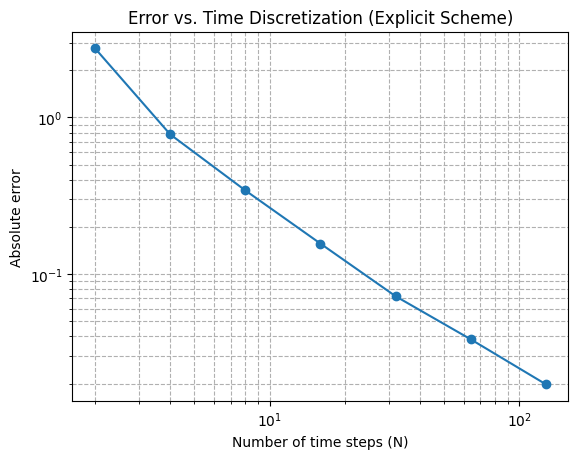

In [35]:
# ----- Experiment 1: Varying number of time steps (with fixed large Monte Carlo samples) -----
num_samples_fixed = 10000  # fixed number of Monte Carlo samples
N_values = [2**i for i in range(1, 8)]  # e.g. 2^1=2 to 2^11=2048 time steps
errors_dt = []

for N in N_values:
    mc_mean, mc_error = monte_carlo_simulation(problem, x0, T, N, num_samples_fixed)
    error = abs(mc_mean - v_ref)
    errors_dt.append(error)
    print(f"Time steps: {N:4d} | MC Cost: {mc_mean:.4f} ± {mc_error:.4f} | Error: {error:.4f}")

plt.figure()
plt.loglog(N_values, errors_dt, marker='o')
plt.xlabel("Number of time steps (N)")
plt.ylabel("Absolute error")
plt.title("Error vs. Time Discretization (Explicit Scheme)")
plt.grid(True, which="both", ls="--")
plt.show()

Convergence rate:
* From the first plot, we can conclude that your numerical method converges with approximately first order (slope ≈−1) in the number of time steps 
$N$ for the weak approximation of the LQR cost.

Samples:     8 | MC Cost: 0.8919 ± 0.1076 | Error: 0.1097
Samples:    32 | MC Cost: 0.7192 ± 0.0386 | Error: 0.0629
Samples:   128 | MC Cost: 0.7895 ± 0.0196 | Error: 0.0074
Samples:   512 | MC Cost: 0.7737 ± 0.0104 | Error: 0.0084


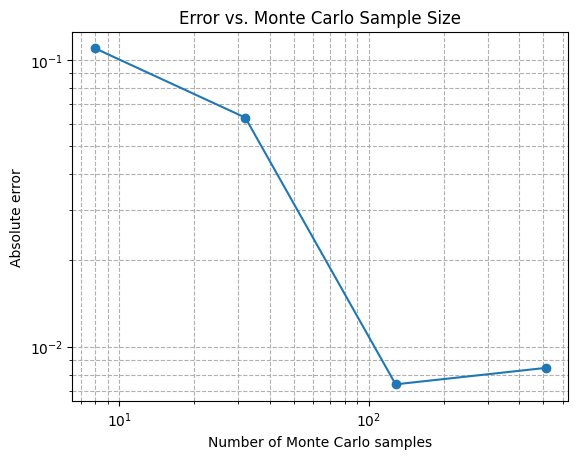

In [41]:
# ----- Experiment 2: Varying number of Monte Carlo samples (with fine time discretization) -----
N_fine = 5000  # choose a very fine time grid
sample_sizes = [2*(4**i) for i in range(1, 5)]  
errors_mc = []

for num_samples in sample_sizes:
    mc_mean, mc_error = monte_carlo_simulation(problem, x0, T, N_fine, num_samples)
    error = abs(mc_mean - v_ref)
    errors_mc.append(error)
    print(f"Samples: {num_samples:5d} | MC Cost: {mc_mean:.4f} ± {mc_error:.4f} | Error: {error:.4f}")

plt.figure()
plt.loglog(sample_sizes, errors_mc, marker='o')
plt.xlabel("Number of Monte Carlo samples")
plt.ylabel("Absolute error")
plt.title("Error vs. Monte Carlo Sample Size")
plt.grid(True, which="both", ls="--")
plt.show()

Convergence rate:
* From the second plot, we can conclude that your numerical method converges with approximately $\mathcal O(N^{-1/2})$ (slope ≈−1/2) in the number of samples
$N$ for the weak approximation of the LQR cost.

## Exercise 2

The class for softLQR is stored in ***SoftLQR.py***.

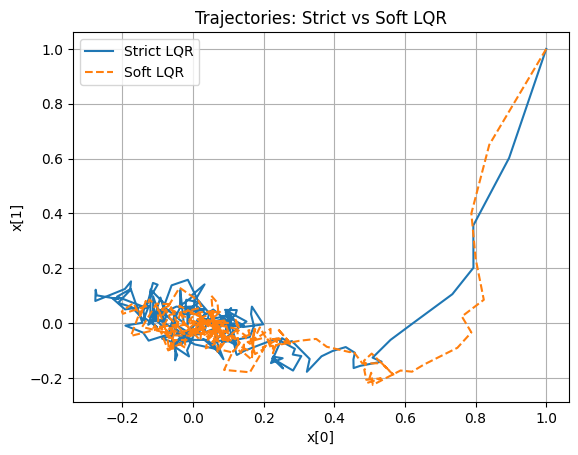

In [42]:
from  SoftLQR import SoftLQRProblem, simulate_trajectory # type: ignore
# ----------------- Main Experiment -----------------
if __name__ == "__main__":
    # Define problem parameters based on the derivations in :contentReference[oaicite:1]{index=1}.
    H = torch.tensor([[1.0, 0.8],
                      [0.1, 0.3]], dtype=torch.float32)
    M = torch.tensor([[0.3, 0.1],
                      [0.8, 1.0]], dtype=torch.float32)
    sigma = 0.5 * torch.eye(2)
    C = 10 * torch.eye(2)
    D = 0.005 * torch.eye(2)
    R = 100 * torch.eye(2)
    T = 1.0
    time_grid = np.linspace(0, T, 1000)
    
    # Set the entropic regularization parameters.
    tau = 1/10
    gamma = 10.0
    
    # Create instances of strict and soft LQR problems.
    strict_problem = LQRProblem(H, M, sigma, C, D, R, T, time_grid)
    soft_problem = SoftLQRProblem(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Choose an initial state.
    x0 = torch.tensor([1.0, 1.0])
    N = 200  # Number of time steps for simulation.
    
    # Simulate trajectories.
    traj_strict = simulate_trajectory(strict_problem, x0, T, N, use_soft=False)
    traj_soft   = simulate_trajectory(soft_problem, x0, T, N, use_soft=True)
    
    # Plot the trajectories for comparison.
    plt.figure()
    plt.plot(traj_strict[:,0], traj_strict[:,1], label="Strict LQR")
    plt.plot(traj_soft[:,0], traj_soft[:,1], '--', label="Soft LQR")
    plt.xlabel("x[0]")
    plt.ylabel("x[1]")
    plt.title("Trajectories: Strict vs Soft LQR")
    plt.legend()
    plt.grid(True)
    plt.show()


## Exercise 3
The class is stored in ***Criticonly.py***.

Epoch 0: Loss = 6.87e+04
Epoch 500: Loss = 2.57e+03
Epoch 1000: Loss = 2.55e+03
Epoch 1500: Loss = 3.81e+03
Epoch 2000: Loss = 3.35e+03
Epoch 2500: Loss = 3.25e+03
Epoch 3000: Loss = 3.56e+03
Epoch 3500: Loss = 4.00e+03
Epoch 4000: Loss = 4.54e+03
Epoch 4500: Loss = 4.56e+03


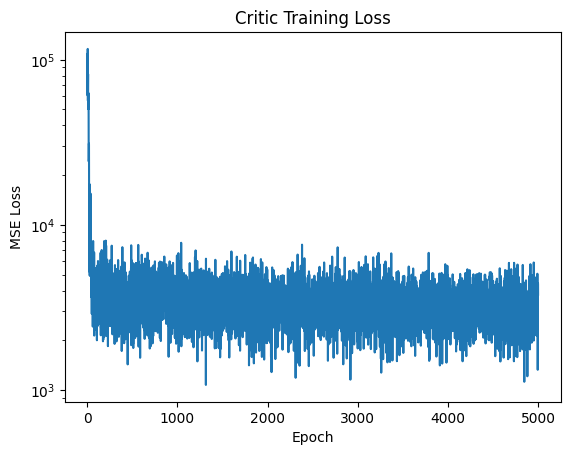

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from Criticonly import CriticNN, generate_training_data, critic_value# type: ignore
# ----------------- Main Training Loop (Critic-Only Algorithm) -----------------
if __name__ == "__main__":
    # Set up soft LQR problem parameters for the critic:
    # Use D = I, T = 0.5, tau = 0.5, gamma = 1, and simulate with N = 100 time steps.
    T = 0.5
    H = torch.tensor([[1.0, 0.8],
                      [0.1, 0.3]], dtype=torch.float32)
    M = torch.tensor([[0.3, 0.1],
                      [0.8, 1.0]], dtype=torch.float32)
    sigma = 0.5 * torch.eye(2)
    C = 10 * torch.eye(2)
    D = torch.eye(2)  # D = I as specified.
    R = 100 * torch.eye(2)
    time_grid = np.linspace(0, T, 1000)
    tau = 0.5
    gamma = 1.0

    # Create an instance of the soft LQR problem (from Exercise 2).
    soft_problem = SoftLQRProblem(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Create the critic network.
    device = torch.device("cpu")
    critic = CriticNN(hidden_size=512, device=device).to(device)
    optimizer = optim.Adam(critic.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    
    # Generate a pool of training data.
    num_samples = 1024
    N_sim = 100  # simulation steps per trajectory
    ts_data, xs_data, targets_data = generate_training_data(soft_problem, T, num_samples, N_sim)
    
    # Training loop.
    num_epochs = 5000
    batch_size = 64
    losses = []
    
    for epoch in range(num_epochs):
        indices = np.random.choice(len(ts_data), batch_size, replace=False)
        t_batch = ts_data[indices].to(device)       # shape: (batch_size, 1)
        x_batch = xs_data[indices].to(device)         # shape: (batch_size, 2)
        target_batch = targets_data[indices].to(device)  # shape: (batch_size,)
        
        # Compute critic's prediction: V(t,x)= xᵀ S(t)x + b(t)
        pred = critic_value(critic, t_batch, x_batch)
        loss = loss_fn(pred, target_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.2e}")
    
    # Plot training loss (log scale for clarity)
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Critic Training Loss")
    plt.yscale("log")
    plt.show()


The results indicate that the critic network initially learned quickly—evidenced by a dramatic drop in loss from about 68,700 at epoch 0 to roughly 2,570 at epoch 500. However, after that initial improvement, the loss plateaus and even increases slightly (reaching around 4,560 by epoch 4,500). This suggests several things:

* Rapid Initial Learning: The network was able to capture a rough approximation of the value function quickly.

* Plateauing Performance: After epoch 500, the loss stops decreasing significantly, indicating that the network may have reached a local minimum or plateau in terms of learning.

* Possible Instability or Noise: The increase in loss after epoch 1,000 might be due to noise in the Monte Carlo estimates of the cost-to-go or could indicate that the current network architecture, hyperparameters, or training data are limiting further improvements.

* Need for Tuning: To lower the loss further, it may be necessary to adjust the network architecture, learning rate, or batch size, or to collect more training data to reduce the variance in the cost estimates.

## Exercise 4

Epoch 0: Loss = 1.94e+04
Epoch 500: Loss = 3.97e+04
Epoch 1000: Loss = 1.07e+04
Epoch 1500: Loss = 3.08e+03
Epoch 2000: Loss = 3.27e+04
Epoch 2500: Loss = 1.71e+03
Epoch 3000: Loss = 2.64e+03
Epoch 3500: Loss = 4.42e+03
Epoch 4000: Loss = 5.21e+03
Epoch 4500: Loss = 3.95e+04


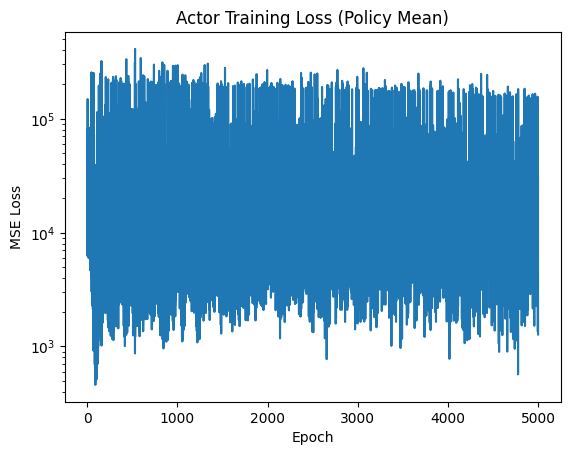

Test times: [0.0, 0.5, 1.0]
Predicted control means: tensor([[ -38.2861,  -24.9298],
        [ -72.1506,  -19.9529],
        [-248.1147,  118.9928]])


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from ActorOnly import ActorNN, generate_actor_data
# ----------------- Main Training Loop for Actor (Exercise 4) -----------------
if __name__ == "__main__":
    # Define soft LQR problem parameters (example values)
    # These should match those used in Exercise 2.
    H = torch.tensor([[1.0, 0.8],
                      [0.1, 0.3]], dtype=torch.float32)
    M = torch.tensor([[0.3, 0.1],
                      [0.8, 1.0]], dtype=torch.float32)
    sigma = 0.5 * torch.eye(2)
    C = 10 * torch.eye(2)
    D = 0.005 * torch.eye(2)   # In Exercise 4, you might set D = I for simplicity; adjust as needed.
    R = 100 * torch.eye(2)
    T = 1.0
    time_grid = np.linspace(0, T, 1000)
    tau = 1/10
    gamma = 10.0

    # Create an instance of the soft LQR problem (from Exercise 2)
    soft_problem = SoftLQRProblem(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Set up the actor network.
    state_dim = H.shape[0]
    control_dim = D.shape[0]  # control dimension
    actor = ActorNN(state_dim, control_dim, hidden_size=256)
    
    optimizer = optim.Adam(actor.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    
    # Generate training data for the actor.
    num_samples = 1024
    ts_data, xs_data, targets_data = generate_actor_data(soft_problem, T, num_samples)
    
    # Training loop for the actor.
    num_epochs = 5000
    batch_size = 64
    losses = []
    
    for epoch in range(num_epochs):
        indices = np.random.choice(len(ts_data), batch_size, replace=False)
        t_batch = ts_data[indices]         # shape: (batch_size, 1)
        x_batch = xs_data[indices]         # shape: (batch_size, state_dim)
        target_batch = targets_data[indices]  # shape: (batch_size, control_dim)
        
        # Actor's prediction of control mean.
        pred = actor(t_batch, x_batch)
        loss = loss_fn(pred, target_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.2e}")
    
    # Plot training loss.
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Actor Training Loss (Policy Mean)")
    plt.yscale("log")
    plt.show()
    
    # Optionally, test the actor on some (t,x) samples and compare with the target.
    test_t = torch.tensor([[0.0], [T/2], [T]], dtype=torch.float32)
    # For testing, choose a fixed state (or a batch of states).
    test_x = torch.tensor([[1.0, 1.0]] * test_t.shape[0], dtype=torch.float32)
    with torch.no_grad():
        pred_test = actor(test_t, test_x)
    print("Test times:", test_t.squeeze().tolist())
    print("Predicted control means:", pred_test)


## Exercise 5

Episode 0: Actor loss = -4.84e+00, Critic loss = 7.15e+04
Episode 500: Actor loss = -4.36e+00, Critic loss = 1.15e+04
Episode 1000: Actor loss = -1.63e+01, Critic loss = 3.70e+05
Episode 1500: Actor loss = -1.39e+01, Critic loss = 1.84e+05


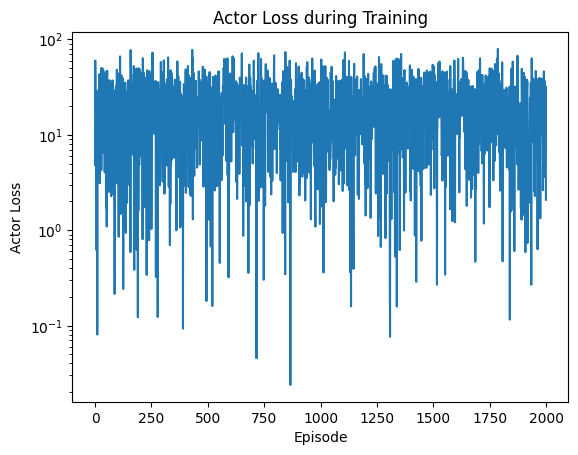

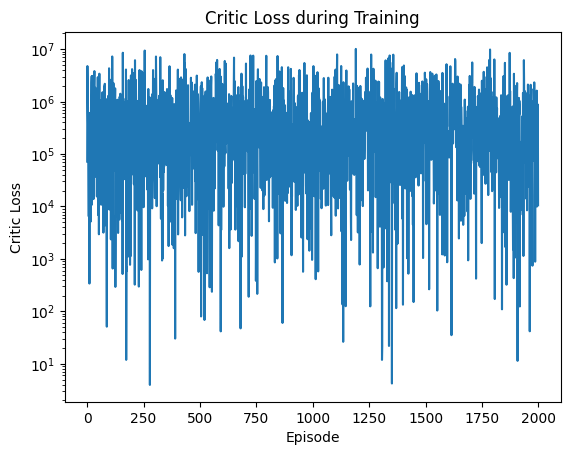

In [76]:
from SoftLQR import SoftLQRProblem
from ActorOnly import ActorNN
from Criticonly import CriticNN
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# ---------- Helper Function: Actor Distribution ----------
def get_actor_distribution(actor, t, x, fixed_cov):
    """
    Given the actor network, time t (tensor of shape (batch,1)) and state x (tensor of shape (batch, state_dim)),
    returns a MultivariateNormal distribution with mean predicted by the actor and fixed covariance.
    """
    mean = actor(t, x)  # shape: (batch, control_dim)
    return torch.distributions.MultivariateNormal(mean, covariance_matrix=fixed_cov)

# ---------- Episode Simulation Function ----------
def simulate_episode(actor, critic, soft_problem, T, N, actor_cov):
    dt = T / N
    t_grid = torch.linspace(0, T, N+1)
    state_dim = soft_problem.H.shape[0]
    # Sample initial state uniformly from [-2,2]^state_dim.
    x = torch.tensor(np.random.uniform(-2, 2, size=(state_dim,)), dtype=torch.float32)
    
    times = []
    states = []
    actions = []
    logprobs = []  # Keep these as tensors (do not call .item())
    costs = []
    critic_values = []
    
    for n in range(N):
        t = t_grid[n].unsqueeze(0)  # shape: (1,)
        times.append(t.item())
        states.append(x.clone())
        
        # Compute critic estimate V(t,x) = xᵀ S(t)x + b(t)
        # Ensure x is shaped as (1, state_dim, 1)
        x_exp = x.unsqueeze(0).unsqueeze(2)  # shape: (1, state_dim, 1)
        S, b = critic(t.unsqueeze(0))         # critic output for batch size 1.
        v_current = torch.bmm(x_exp.transpose(1,2), torch.bmm(S, x_exp)).squeeze() + b.squeeze()
        # Detach critic values for use as constants in the actor loss.
        critic_values.append(v_current.detach().item())
        
        # Sample action using actor.
        dist = get_actor_distribution(actor, t.unsqueeze(0), x.unsqueeze(0), actor_cov)
        a = dist.sample().squeeze(0)  # Now a has shape (control_dim,)
        actions.append(a.clone())
        # Append the log probability tensor (do not call .item() here).
        logprobs.append(dist.log_prob(a.unsqueeze(0)))
        
        # Running cost: f = xᵀ C x + aᵀ D a.
        cost = (x @ (soft_problem.C @ x) + a @ (soft_problem.D @ a)).item()
        costs.append(cost)
        
        # Euler–Maruyama state update.
        dW = torch.randn(x.shape) * np.sqrt(dt)
        x = x + dt * (soft_problem.H @ x + soft_problem.M @ a) + soft_problem.sigma @ dW
        
    # Terminal step.
    t_final = t_grid[-1].unsqueeze(0)
    times.append(t_final.item())
    states.append(x.clone())
    x_exp = x.unsqueeze(0).unsqueeze(2)  # shape: (1, state_dim, 1)
    S, b = critic(t_final.unsqueeze(0))
    v_final = torch.bmm(x_exp.transpose(1,2), torch.bmm(S, x_exp)).squeeze() + b.squeeze()
    critic_values.append(v_final.detach().item())
    terminal_cost = (x @ (soft_problem.R @ x)).item()
    
    # Compute TD errors: δ_n = V(t_{n+1}, x_{n+1}) - V(t_n, x_n)
    td_errors = []
    for n in range(N):
        delta = critic_values[n+1] - critic_values[n]
        td_errors.append(delta)
    
    episode_data = {
        'times': times,
        'states': states,
        'actions': actions,
        # Stack the logprob tensors into one tensor.
        'logprobs': torch.cat(logprobs, dim=0),  
        'costs': costs,
        'td_errors': td_errors,
        'terminal_cost': terminal_cost,
        'dt': dt
    }
    return episode_data

# ---------- Main Actor-Critic Training Loop (Exercise 5) ----------
if __name__ == "__main__":
    # Define problem parameters.
    T = 0.5
    state_dim = 2
    control_dim = 2
    H = torch.tensor([[1.0, 0.8],
                      [0.1, 0.3]], dtype=torch.float32)
    M = torch.tensor([[0.3, 0.1],
                      [0.8, 1.0]], dtype=torch.float32)
    sigma = 0.5 * torch.eye(2)
    C = 10 * torch.eye(2)
    # For actor–critic, set D = I.
    D = torch.eye(2)
    R = 100 * torch.eye(2)
    time_grid = np.linspace(0, T, 1000)
    tau = 0.5
    gamma = 1.0
    
    # Create soft LQR problem instance.
    soft_problem = SoftLQRProblem(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Create actor and critic networks.
    actor = ActorNN(state_dim, control_dim, hidden_size=256)
    critic = CriticNN(hidden_size=512, device=torch.device("cpu"))
    
    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-10)
    critic_optimizer = optim.Adam(critic.parameters(), lr=1e-12)
    
    # Fixed covariance for actor policy: use theoretical covariance.
    m = D.shape[0]
    A = D + (tau/(2*gamma**2)) * torch.eye(m)
    actor_cov = tau * A  # fixed covariance.
    
    num_episodes = 2000
    actor_losses = []
    critic_losses = []
    
    for episode in range(num_episodes):
        ep_data = simulate_episode(actor, critic, soft_problem, T, N=100, actor_cov=actor_cov)
        # td_errors is a list of Python floats.
        td_errors = torch.tensor(ep_data['td_errors'], dtype=torch.float32)
        # logprobs is now a tensor from stacking the raw log probabilities.
        logprobs = ep_data['logprobs']
        costs = torch.tensor(ep_data['costs'], dtype=torch.float32)
        dt_ep = ep_data['dt']
        
        extra_terms = costs + tau * logprobs
        # Compute actor loss using REINFORCE-style update:
        # We treat td_errors as constant (detached) and backpropagate through logprobs.
        actor_loss = - (logprobs.dot(td_errors) + extra_terms.sum() * dt_ep)
        
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        actor_losses.append(actor_loss.item())
        
        # Critic update: target return G = (∑ f*dt) + terminal cost.
        G = dt_ep * costs.sum() + ep_data['terminal_cost']
        x0 = ep_data['states'][0].unsqueeze(0)
        t0 = torch.tensor([[0.0]], dtype=torch.float32)
        x0_exp = x0.unsqueeze(2)  # shape: (1, state_dim, 1)
        S, b = critic(t0)
        v_pred = torch.bmm(x0_exp.transpose(1,2), torch.bmm(S, x0_exp)).squeeze() + b.squeeze()
        critic_loss = (v_pred - G)**2
        
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        critic_losses.append(critic_loss.item())
        
        if episode % 500 == 0:
            print(f"Episode {episode}: Actor loss = {actor_loss.item():.2e}, Critic loss = {critic_loss.item():.2e}")
    
    plt.figure()
    plt.plot(np.abs(actor_losses))
    plt.xlabel("Episode")
    plt.ylabel("Actor Loss")
    plt.title("Actor Loss during Training")
    plt.yscale("log")
    plt.show()
    
    plt.figure()
    plt.plot(critic_losses)
    plt.xlabel("Episode")
    plt.ylabel("Critic Loss")
    plt.title("Critic Loss during Training")
    plt.yscale("log")
    plt.show()
